# Text Feature Visualization & Text Search
This tutorial demonstrates how to search layer channels with text & how to perform text feature visualization on the CLIP ResNet 50x4 model as described in the [Multimodal Neurons in Artificial Neural Networks](https://distill.pub/2021/multimodal-neurons/) research paper.

In [ ]:
%load_ext autoreload
%autoreload 2


import html
from typing import Callable, List, Optional, Tuple, Union
from warnings import warn

import captum.optim as opt
import regex as re
import torch
from captum.optim.models import clip_resnet50x4_text, clip_resnet50x4_image
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setup

To start off, we'll define multiple helper functions and classes.

In [ ]:
class PreprocessTextCLIP(torch.nn.Module):
    """
    Preprocess text strings as per OpenAI's standard CLIP preprocessing / cleaning.

    See here for more information:
    https://ftfy.readthedocs.io/en/latest/
    https://docs.python.org/3/library/html.html#html.unescape
    https://github.com/openai/CLIP/blob/main/clip/simple_tokenizer.py
    """

    __constants__ = ["use_ftfy"]

    def __init__(self) -> None:
        super().__init__()
        try:
            import ftfy

            self.use_ftfy = True
        except (ImportError, AssertionError):
            warn(
                "Warning the ftfy library was not found, and thus heuristic unicode"
                + " correction will not be used in the CLIPTokenizer preprocessing"
                + " module. The library can be installed via 'pip install ftfy'"
            )
            self.use_ftfy = False

    @torch.jit.ignore
    def forward(self, x: List[str]) -> List[str]:
        """
        Args:

            x (str or list of str): One or more strings to be cleaned.

        Returns:
            x (str or list of str): A list of preprocessed / cleaned strings.
        """
        assert all([isinstance(s, str) for s in x])
        for i in range(len(x)):
            # Heuristic unicode fixing (ex: mojibake)
            if self.use_ftfy:
                x[i] = ftfy.fix_text(x[i])

            # Convert named & numeric character references in HTML to unicode
            x[i] = html.unescape(html.unescape(x[i]))

            # Remove duplicate whitespaces
            x[i] = re.sub(r"\s+", " ", x[i].strip()).strip()

            # Only use lowercase characters
            x[i] = x[i].lower()
        return x


class CLIP_ResNet50x4(torch.nn.Module):
    """
    Wrapper for combining the text and image portions of a CLIP model into the full
    model.
    """

    def __init__(
        self, image_model: torch.nn.Module, text_model: torch.nn.Module
    ) -> None:
        """
        Args:

            image_model (nn.Module): A PyTorch model instance that takes image inputs.
            text_model (nn.Module): A PyTorch model instance that takes text inputs.
        """
        super().__init__()
        self.image_model = image_model
        self.text_model = text_model

    def forward(
        self, x: Union[Tuple[torch.Tensor, torch.Tensor], List[torch.Tensor]]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:

            x (tuple or list of torch.Tensor): A tuple or list of tensors, with the
                format: [image_tensor, text_tensor].

        Returns:
            logits_per_text (torch.Tensor): The model output.
        """
        assert len(x) == 2
        image, text = x
        image_features = self.image_model(image)
        text_features = self.text_model(text)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.text_model.logit_scale.exp()

        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_image, logits_per_text


def get_text_layer_attr(
    model: torch.nn.Module, layer_target: torch.nn.Module, text_inputs: torch.Tensor
) -> torch.Tensor:
    """
    Args:

        model (nn.Module): A PyTorch model instance.
        layer_target (nn.Module): A target layer instance.
        text_inputs (torch.Tensor): A text input to pass through the text portion of
            the model.

    Returns
        grad (torch.Tensor): Attributions for the target layer.
    """
    grad = []
    for i in range(text_inputs.shape[0]):
        model_inputs = (
            torch.nn.Parameter(torch.zeros(1, 3, 288, 288).to(text_inputs.device)),
            text_inputs[i : i + 1].clone(),
        )
        attr_activations = opt.models.collect_activations(
            model, [layer_target, model], model_inputs
        )
        target_activ = attr_activations[layer_target]
        logit_activ = attr_activations[model][1]
        grad_b = torch.autograd.grad(
            outputs=logit_activ,
            inputs=[target_activ],
            grad_outputs=torch.ones_like(logit_activ),
        )[0].detach()
        grad.append(grad_b)
    return torch.cat(grad, 0)


def int_token_tokenizer(
    x: List[int],
    context_length: int = 77,
    start_token: int = 49406,
    end_token: int = 49407,
    padding_value: int = 0,
    start_from_tokens: List[int] = [],
    end_with_tokens: List[int] = [],
) -> torch.Tensor:
    """
    Apply special tokens and padding to sets of tokens in integer list format.

    Args:

        context_length (int, optional): The required context length for the model.
            Inputs with lengths less than context_length will be padded with
            zeros.
            Default: 77
        start_token (str, optional): The starting token to place in front of each
            text input. Set to None for no start token.
            Default: "<|startoftext|>"
        end_token (str, optional): The ending token to place at the end of each
            text input. Set to None for no end token.
            Default: "<|endoftext|>"
        padding_value (int, optional): An integer value to use for padding token
            sets to the desired context_length.
            Default: 0
        start_from_tokens (list of int, optional): Optionally add one or more
            starting tokens to each input.
            Default: []
        end_with_tokens (list of int, optional): Optionally add one or more
            ending tokens to each input.
            Default: []

    Returns:
        tokens (torch.Tensor): A tensors containing the token sets stacked across the
            batch dimension.
    """
    tokens = [
        [start_token] + start_from_tokens + [t] + end_with_tokens + [end_token]
        for t in x
    ]
    tokens = [
        token_set + ([padding_value] * (context_length - len(token_set)))
        for token_set in tokens
    ]
    return torch.as_tensor(tokens).int()

We load both the image and text models, and then place them inside our `CLIP_ResNet50x4` wrapper class to create the full CLIP model. We also load the CLIP tokenizer, and some additional variables.

In [ ]:
# Load the CLIP ResNet 50x4 model
clip_model_text = clip_resnet50x4_text(pretrained=True).eval().to(device)
clip_model_image = (
    clip_resnet50x4_image(
        pretrained=True, replace_relus_with_redirectedrelu=False, use_attnpool=True
    )
    .eval()
    .to(device)
)
clip_model_full = CLIP_ResNet50x4(clip_model_image, clip_model_text)

# Setup tokenizer
clip_tokenizer = opt.transforms.CLIPTokenizer(
    pretrained_merges=True, preprocessing_module=PreprocessTextCLIP()
)

# Setup tokenizer vocab range & logit scale
token_vocab_range = list(range(0, 49405))  # Standard CLIP tokens are [0-49405]
logit_scale = clip_model_text.logit_scale.exp()

## Searching CLIP Image Layer Channels With Text

This portion of the tutorial demonstrates how to use the text portion of the CLIP ResNet 50x4 model to search layer channels in the image portion of the model.

Below we show how to search target image layers for channels that relate to our text inputs!

In [ ]:
text = "kitten"  # Change to any text input or list of text inputs
text_inputs = clip_tokenizer(text).to(device)

# Set target layer as penultimate image model layer
target = clip_model_full.image_model.layer4[5]

# Get attributions for target layer in relation to given text inputs
layer_attr = get_text_layer_attr(clip_model_full, target, text_inputs)

# Set the number of results to show
num_results = 5


for b in range(layer_attr.shape[0]):
    # Sort results
    channel_strengths = torch.stack(
        [-torch.linalg.norm(layer_attr[b, i, :, :]) for i in range(layer_attr.shape[1])]
    )
    top_channels = torch.argsort(channel_strengths)[:num_results]

    # Show results
    b_text = text if isinstance(text, str) else text[b]
    print(
        "Top {} channels of the target layer for the text '{}' with the largest L2-norm: \n {} ".format(
            list(top_channels.size())[0], b_text, top_channels.tolist()
        )
    )
    print(" {}".format(channel_strengths[top_channels].tolist()))

Top 5 channels of the target layer for the text 'kitten' with the largest L2-norm: 
 [289, 1179, 607, 1543, 1124] 
 [-1.4196891784667969, -0.7648456692695618, -0.6109495759010315, -0.5101999044418335, -0.5019273161888123]


We can see that the text input `"kitten"` corresponds most strongly to channel number `289` in the target layer. As the second strongest channel is significantly lower than the first, we can reasonably conclude that channel `289` is the image model's "kitten" channel.

## Similarity Search


CLIP models produce text & image embeddings that can be used to calculate the similarity between different images and text strings.

Below we define a helper function for comparing embedding similarity, by searching through the model's entire vocab token range.

In [ ]:
def embedding_token_search(
    text_model: torch.nn.Module,
    target_embeddings: torch.Tensor,
    token_list: List[int],
    batch_size: int = 32,
    logit_scale: float = 100,
    device: torch.device = torch.device("cpu"),
    start_from_tokens: List[int] = [],
    end_with_tokens: List[int] = [],
    tokenizer_fn: Callable[[List[int]], List[int]] = int_token_tokenizer,
) -> List[float]:
    """
    Args:

        text_model (nn.Module): A PyTorch model instance.
        target_embeddings (torch.Tensor): A set of normalized image or text embeddings
            to find the maximal token for, with a shape of: [1, n_vals].
        token_list (list of int): A list of tokens to search through.
        batch_size (int, optional): The desired batch size to use.
            Default: 32
        device (torch.device, optional): The desired device to use.
            Default: torch.device("cpu")
        start_from_tokens (list of int, optional): A list of one or more tokens to use
            a prefix for the token search.
            Default: []
        end_with_tokens (list of int, optional): A list of one or more tokens to use
            a suffix for the token search.
            Default: []
        tokenizer_fn (callable, optional): A function that takes a list of integer
            token sets and applies padding & special tokens.
            Default: int_token_tokenizer

    Returns:
        logits_text_list (list of float): A list of values corresponding to the order
            in token_list.
    """
    assert target_embeddings.dim() == 2 and target_embeddings.shape[0] == 1
    logits_text_list = []

    for i in tqdm(range(0, len(token_list), batch_size)):
        # Prepare input tokens
        token_batch = token_list[i : i + batch_size]
        token_set = tokenizer_fn(
            token_batch,
            start_from_tokens=start_from_tokens,
            end_with_tokens=end_with_tokens,
        ).to(device)

        text_embeddings = text_model(token_set).detach()
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

        logits_per_text = logit_scale * text_embeddings @ target_embeddings.t()
        logits_text_list += logits_per_text[:, 0].tolist()

    return logits_text_list

### Text Similarity

The similarity of two different text embeddings produced by the text portion of the model can easily be determined in the same way similarity between image and text embeddings is calculated.

In [ ]:
# Setup target embedding
text_input = "machine learning"
text_tokens = clip_tokenizer(text_input).to(device)
text_embeddings = clip_model_text(text_tokens).detach()
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

# Compare target embedding with full token list
logits_text_list = embedding_token_search(
    text_model=clip_model_text,
    target_embeddings=text_embeddings,
    token_list=token_vocab_range,
    batch_size=32,
    logit_scale=logit_scale,
    device=device,
)

# Sort results
num_tokens = 10
top_tokens_text = torch.argsort(torch.as_tensor(logits_text_list), descending=True)[
    0:num_tokens
]

# Decode results
top_tokens_str = [clip_tokenizer.decode(t)[0] for t in top_tokens_text.unsqueeze(1)]

# Display results
print(
    "Top {} most similar tokens for the input text is: \n  {} ".format(
        num_tokens, top_tokens_text.tolist()
    )
)
print("The top tokens decoded are: \n  {} ".format(top_tokens_str))

  0%|          | 0/1544 [00:00<?, ?it/s]

Top 10 most similar tokens for the input text is: 
  [13621, 20799, 24362, 15748, 9440, 4169, 10831, 8558, 5882, 10581] 
The top tokens decoded are: 
  ['machinelearning', 'artificialintelligence', 'deeplearning', 'datascience', 'bigdata', 'machine', 'programming', 'analytics', 'startup', 'cybersecurity'] 


As you can see, the model associates the term `"machine learning"` with a variety of similar and related topics.

### Image Similarity

Given an input image, we can find the most similar tokens to it by comparing text embeddings to the image's embedding.

Below we collect embeddings for an input image.

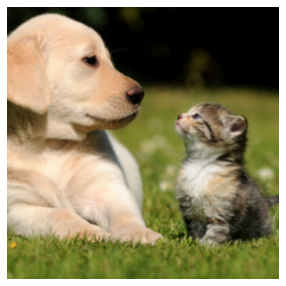

In [ ]:
# Path or URL to image file
image_url_or_path = (
    "https://user-images.githubusercontent.com/"
    + "10626398/145851549-69251f3b-3b52-4d55-9db4-878c52685377.png"
)
input_image = opt.images.ImageTensor.open(image_url_or_path).unsqueeze(0).to(device)

# Resize to model's input requirement
input_image = torch.nn.functional.interpolate(
    input_image, size=(288, 288), antialias=True, mode="bilinear"
).clamp(0, 1)
opt.images.show(input_image, figsize=(5, 5))
image_embedding = clip_model_image(input_image).detach()

image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)

Next we search the full vocab token range with the image embeddings that we collected above.

In [ ]:
# Collect text embedding similarities
logits_text_list = embedding_token_search(
    text_model=clip_model_text,
    target_embeddings=image_embedding,
    token_list=token_vocab_range,
    batch_size=32,
    logit_scale=logit_scale,
    device=device,
)

# Sort results
num_tokens = 10
top_tokens_text = torch.argsort(torch.as_tensor(logits_text_list), descending=True)[
    0:num_tokens
]

# Decode results
top_tokens_str = [clip_tokenizer.decode(t)[0] for t in top_tokens_text.unsqueeze(1)]

# Display results
print(
    "Top {} most similar tokens for the input image is: \n  {} ".format(
        num_tokens, top_tokens_text.tolist()
    )
)
print("The top tokens decoded are: \n  {} ".format(top_tokens_str))

  0%|          | 0/1544 [00:00<?, ?it/s]

Top 10 most similar tokens for the input image is: 
  [40849, 35996, 38536, 42674, 17216, 19674, 20778, 38428, 14820, 14653] 
The top tokens decoded are: 
  ['puppylove', 'fostering', 'tolerant', 'friendship', 'kittens', 'adoptdont', 'pups', 'lief', 'puppies', 'ernity'] 


As we can see in the top tokens, the model associates the image with words related to kittens and puppies.

## Text Feature Visualization

While visualization normally involves rendering images, it is also possible to visualize text.

Text Feature Visualization is performed by algorithmically adding, removing, and changing tokens, in order to maximize the objective of a hill climbing algorithm. This basic approach was used to generate the text prompts for target channels in the [Multimodal Neurons in Artificial Neural Networks](https://distill.pub/2021/multimodal-neurons/) research paper. To improve the algorithm, one of the authors (Gabriel Goh) suggests adding a small [BERT](https://en.wikipedia.org/wiki/BERT_(language_model%29) model as well as using LM penalties on sentences. Though for this tutorial, we will simply iterate through the model's entire vocabulary, by iterating through a list of tokens.

Below we define a helper function for collecting the channel specific attributions for a target layer.

In [ ]:
def channel_token_search(
    full_model: torch.nn.Module,
    target: torch.nn.Module,
    channel_index: Optional[int],
    token_list: List[int],
    batch_size: int = 32,
    logit_scale: float = 100,
    device: torch.device = torch.device("cpu"),
    start_from_tokens: List[int] = [],
    end_with_tokens: List[int] = [],
    tokenizer_fn: Callable[[List[int]], List[int]] = int_token_tokenizer,
) -> Union[List[float], List[List[float]]]:
    """
    Args:

        full_model (nn.Module): A PyTorch model instance.
        target (nn.Module): The target layer to collect attributions from.
        channel_index (int, optional): The desired channel index to collect
            attributions for, in the target layer. Set to None for all channels.
        token_list (list of int): A list of tokens to search through.
        batch_size (int, optional): The desired batch size to use.
            Default: 32
        device (torch.device, optional): The desired device to use.
            Default: torch.device("cpu")
        start_from_tokens (list of int, optional): A list of one or more tokens to use
            a prefix for the token search.
            Default: []
        end_with_tokens (list of int, optional): A list of one or more tokens to use
            a suffix for the token search.
            Default: []
        tokenizer_fn (callable, optional): A function that takes a list of integer
            token sets and applies padding & special tokens.
            Default: int_token_tokenizer

    Returns:
        logits_text_list (list of float or list of list of float): A list of values
            corresponding to the order in token_list.
    """
    logits_text_list = []

    for i in tqdm(range(0, len(token_list), batch_size)):
        # Prepare input tokens
        token_batch = token_list[i : i + batch_size]
        token_set = tokenizer_fn(
            token_batch,
            start_from_tokens=start_from_tokens,
            end_with_tokens=end_with_tokens,
        ).to(device)

        layer_attr = get_text_layer_attr(full_model, target, token_set)
        for b in range(layer_attr.shape[0]):

            if channel_index:
                channel_strengths = -torch.linalg.norm(
                    layer_attr[b, channel_index, ...]
                )
            else:
                channel_strengths = torch.stack(
                    [
                        -torch.linalg.norm(layer_attr[b, c, ...])
                        for c in range(layer_attr.shape[1])
                    ]
                )
            logits_text_list += [channel_strengths.tolist()]

    return logits_text_list

We can now collect attributions for the penultimate layer with a channel index of `289` for the image portion of the CLIP ResNet 50x4 model.

In [ ]:
# Desired target layer & channel index
target_layer = clip_model_full.image_model.layer4[5]
channel_index = 289


# Collect target attributions
logits_text_list = channel_token_search(
    full_model=clip_model_full,
    target=target_layer,
    channel_index=channel_index,
    token_list=token_vocab_range,
    batch_size=32,
    logit_scale=logit_scale,
    device=device,
)

  0%|          | 0/1544 [00:00<?, ?it/s]

After collecting the attributions, we can then sort them and display the results!

In [ ]:
# Sort results
num_tokens = 10
top_tokens_text = torch.argsort(torch.as_tensor(logits_text_list), descending=False)[
    0:num_tokens
]

# Decode results
top_tokens_str = [clip_tokenizer.decode(t)[0] for t in top_tokens_text.unsqueeze(1)]

# Display results
print(
    "Top {} tokens for the target layer channel {} are: \n  {} ".format(
        num_tokens, channel_index, top_tokens_text.tolist()
    )
)
print("The top tokens decoded are: \n  {} ".format(top_tokens_str))

Top 10 tokens for the target layer channel 289 are: 
  [39901, 2368, 36013, 3989, 20892, 37896, 25870, 39965, 22979, 30790] 
The top tokens decoded are: 
  ['catsofinstagram', 'cat', 'kitties', 'cats', 'caturday', 'bobcat', 'wildcat', 'meow', '🐱', 'katz'] 


We can clearly see that the penultimate layer's channel index `289` is focused on concepts relating to cats.